In [3]:
import enem
import pandas as pd

In [4]:
microdata_path = "microdados_enem_2021/DADOS/MICRODADOS_ENEM_2021.csv"

data = enem.select_column(
    microdata_path,
    ['SG_UF_PROVA', 'NU_NOTA_REDACAO', 'Q006']
)

renda_redacao_ = pd.concat(
    data, ignore_index=True
).dropna()
renda_redacao_.rename(
    columns={
        'Q006':'renda',
        'NU_NOTA_REDACAO': 'nota',
        'SG_UF_PROVA': 'estado'
    }, inplace=True
)
renda_redacao_.sample(5)

,estado,nota,renda
1065135,RJ,620.0,F
3054230,SC,680.0,O
484991,MG,620.0,D
692242,SP,880.0,C
1950617,RJ,480.0,C


In [173]:
renda_redacao_= pd.read_pickle('renda_redacao_2021.pkl')
renda_redacao_.sample(6)

,estado,nota,renda
204349,GO,560.0,B
2088603,PI,880.0,B
149827,SP,0.0,A
1243925,SP,880.0,I
1321507,PR,800.0,B
1373736,MA,520.0,M


In [5]:
from pandas_ods_reader import read_ods

In [8]:
microdata_keys_path = "microdados_enem_2021/DICIONÁRIO/Dicionário_Microdados_Enem_2021.ods"
chaves = read_ods(microdata_keys_path, skiprows=1)
chaves.rename(columns=chaves.iloc[0], inplace=True)  # type:ignore
chaves.drop(chaves.index[0], inplace=True)
start = chaves[chaves["NOME DA VARIÁVEL"] == 'Q006'].index[0] - 1  # type:ignore
chave_renda_ = chaves[["Categoria", "Descrição02"]].iloc[start: start + 17]
chave_renda_.reset_index(inplace=True)
chave_renda_.drop(columns=('index'), inplace=True)
chave_renda_.sample(3)''

,Categoria,Descrição02
11,L,"De R$ 8.800,01 até R$ 9.900,00."
7,H,"De R$ 4.400,01 até R$ 5.500,00."
12,M,"De R$ 9.900,01 até R$ 11.000,00."


In [117]:
import re
# adequando os 2 primeiros valores ao padrão buscado
chave_renda_['Descrição02'][0] = "De R$ 0.000,00 até R$ 0.000,00"
chave_renda_['Descrição02'][1] = "De R$ 0.000,00 até R$ 1.100,00"
# padrão em regular expression (regex)
pattern = r'\d{1}.\d{3},\d{2}'
chave_renda = chave_renda_.copy()
# buscando padrão do tipo 00.000,00
# convertendo para valores numéricos e
# alterando cada valor para o máximo de cada linha
for index, row in enumerate(chave_renda['Descrição02']):
    limits = [
        float(n.replace('.', '').replace(',', '.')) \
            for n in re.findall(pattern, row)
    ]
    avg = round(max(limits), 2)
    chave_renda['Descrição02'][index] = avg
# converendo os valores em múltiplos de salário mínimo, que
# corresponde agora ao segundo valor da coluna 'renda'
chave_renda['Descrição02'] /= chave_renda['Descrição02'][1]
chave_renda['Descrição02'] = chave_renda['Descrição02'].apply(lambda x: round(x*2)/2)  # garantir apenas semi-inteiros
chave_renda.head()

,Categoria,Descrição02
0,A,0.0
1,B,1.0
2,C,1.5
3,D,2.0
4,E,2.5


In [131]:
renda = "renda"
nota = "nota"
renda_redacao = renda_redacao_.copy()
for row in chave_renda.iterrows():
    mask = renda_redacao_[renda] == row[1]['Categoria']
    renda_redacao.loc[mask, renda] = row[1]['Descrição02'] #type:ignore 
renda_redacao[nota] = renda_redacao[nota].astype(float)
renda_redacao[renda] = renda_redacao[renda].astype(float)
renda_redacao.sample(5)

,estado,nota,renda
1563453,AM,540.0,1.0
2729316,PR,760.0,2.0
259203,RO,560.0,1.5
697831,RO,680.0,1.5
128725,MT,520.0,1.0


<AxesSubplot: xlabel='estado', ylabel='nota'>

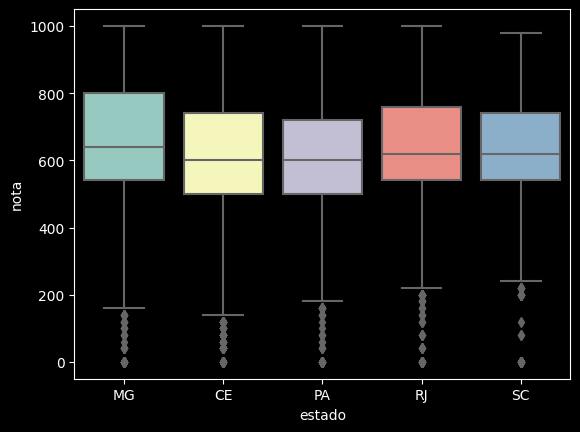

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt
data = renda_redacao[
    renda_redacao["estado"].isin((
        "CE", "PA", "MG", "SC", "RJ"
    ))
]
plt.style.use('dark_background')
sns.boxplot(x="estado", y="nota", data=data)

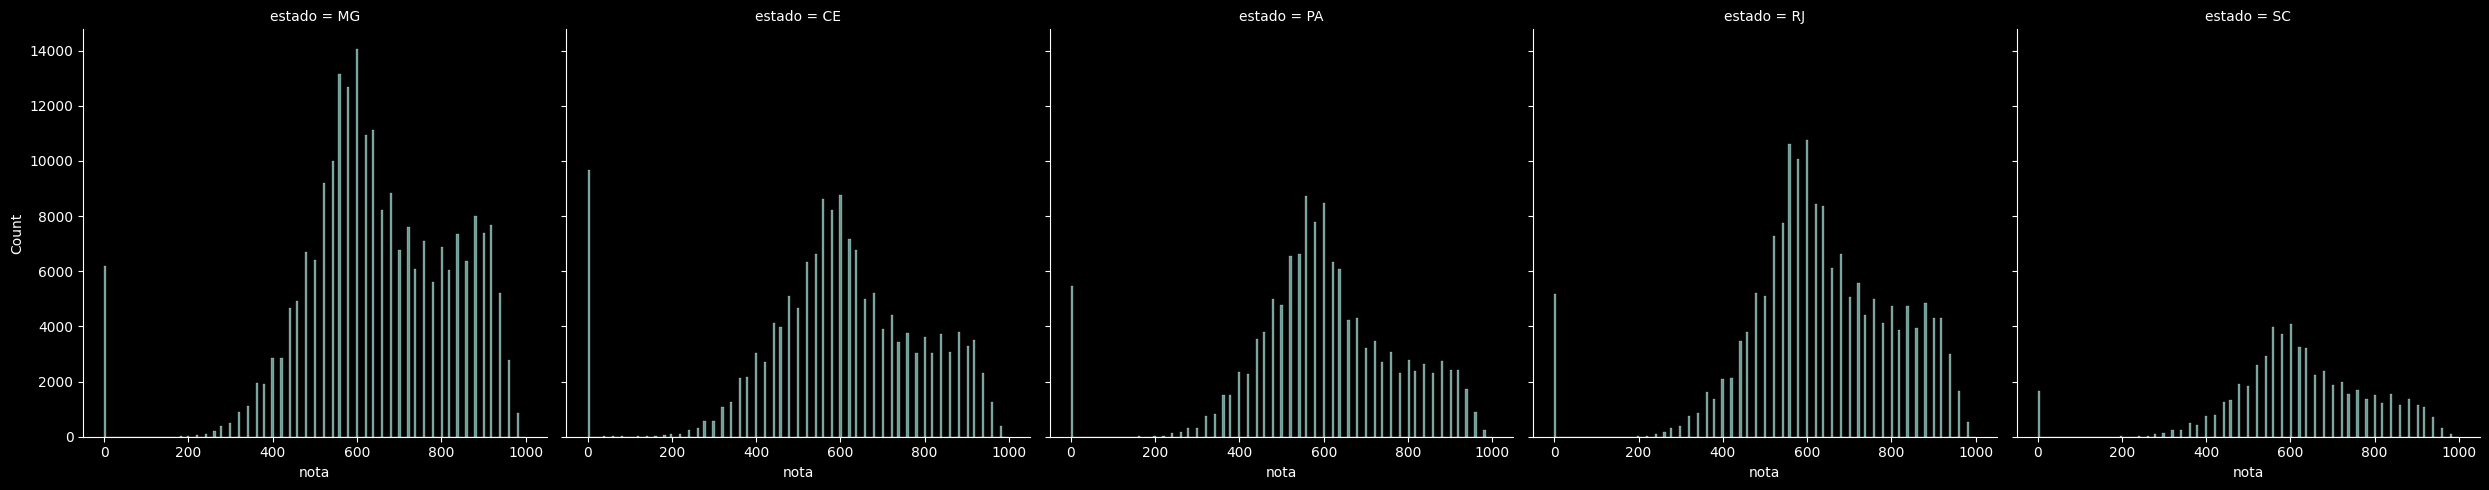

In [136]:
plt.style.use('dark_background')
facetgrid = sns.displot(
    data, x='nota', col='estado', common_norm=False
)
for ax in facetgrid.axes[0]:
    ax.grid(False)

In [137]:
notas = data['nota']
print(notas.value_counts(bins=21)/len(notas)*100)

(619.048, 666.667]    13.226119
(571.429, 619.048]    12.015277
(523.81, 571.429]     10.711836
(476.19, 523.81]      10.673196
(714.286, 761.905]     8.379362
(857.143, 904.762]     7.618501
(666.667, 714.286]     6.535509
(809.524, 857.143]     4.960371
(761.905, 809.524]     4.876855
(428.571, 476.19]      4.728262
(904.762, 952.381]     4.328716
(-1.001, 47.619]       3.825588
(380.952, 428.571]     2.966569
(333.333, 380.952]     2.639421
(952.381, 1000.0]      1.227518
(285.714, 333.333]     0.763301
(238.095, 285.714]     0.434119
(190.476, 238.095]     0.053824
(142.857, 190.476]     0.017354
(95.238, 142.857]      0.010033
(47.619, 95.238]       0.008270
Name: nota, dtype: float64


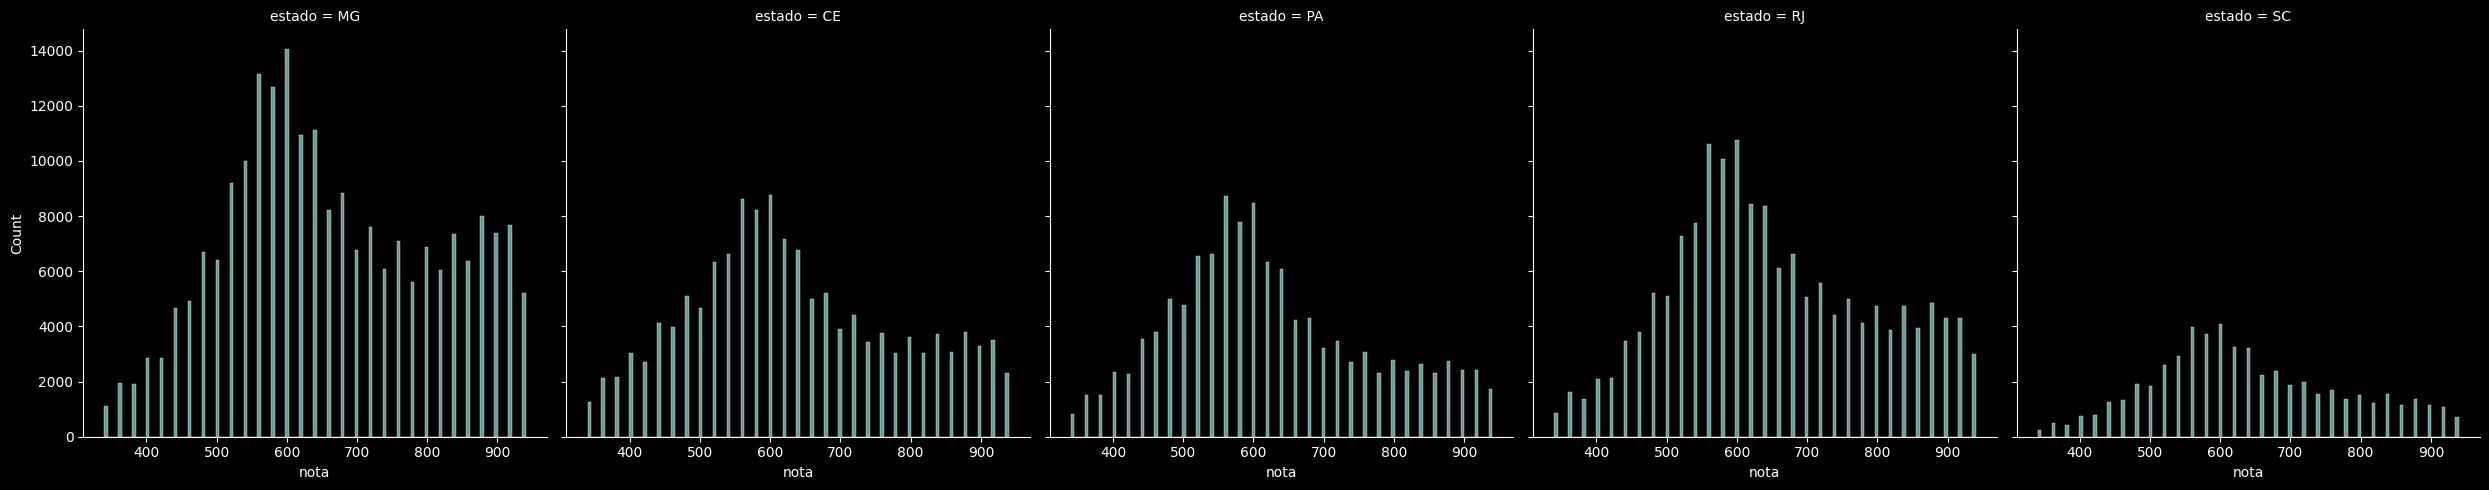

In [138]:
mask1 = data['nota'] > 330
mask2 = data['nota'] < 950
data_filtered = data.loc[mask1 & mask2]
plt.style.use('dark_background')
facetgrid = sns.displot(
    data_filtered, x='nota', col='estado'
)
for ax in facetgrid.axes[0]:
    ax.grid(False)

In [146]:
data = renda_redacao.reset_index()
mask1 = data['nota'] > 220
mask2 = data['nota'] < 1000
data_filtered = data[mask1 & mask2]

In [148]:
correlacao = {}
for estado in data_filtered['estado'].unique():
    dados_estado = data_filtered[data_filtered['estado'] == estado]
    corr = dados_estado.corr(numeric_only=True)['nota'][2]  # type: ignore
    correlacao[estado] = corr
correlacao_ordenada = {k: v for k, v in sorted(correlacao.items(), key=lambda item: item[1])}
for estado in correlacao_ordenada:
    print(f"Correlação nota/renda de {estado}: {round(correlacao_ordenada[estado], 2)}")

Correlação nota/renda de SC: 0.24
Correlação nota/renda de PR: 0.24
Correlação nota/renda de SP: 0.25
Correlação nota/renda de RO: 0.25
Correlação nota/renda de RR: 0.27
Correlação nota/renda de PE: 0.27
Correlação nota/renda de MT: 0.28
Correlação nota/renda de AL: 0.29
Correlação nota/renda de RS: 0.29
Correlação nota/renda de DF: 0.29
Correlação nota/renda de RJ: 0.29
Correlação nota/renda de ES: 0.29
Correlação nota/renda de MG: 0.3
Correlação nota/renda de BA: 0.3
Correlação nota/renda de PA: 0.3
Correlação nota/renda de PB: 0.3
Correlação nota/renda de AC: 0.31
Correlação nota/renda de RN: 0.31
Correlação nota/renda de MA: 0.31
Correlação nota/renda de MS: 0.31
Correlação nota/renda de AM: 0.31
Correlação nota/renda de AP: 0.32
Correlação nota/renda de TO: 0.32
Correlação nota/renda de SE: 0.32
Correlação nota/renda de CE: 0.32
Correlação nota/renda de GO: 0.32
Correlação nota/renda de PI: 0.33


<AxesSubplot: xlabel='nota', ylabel='estado'>

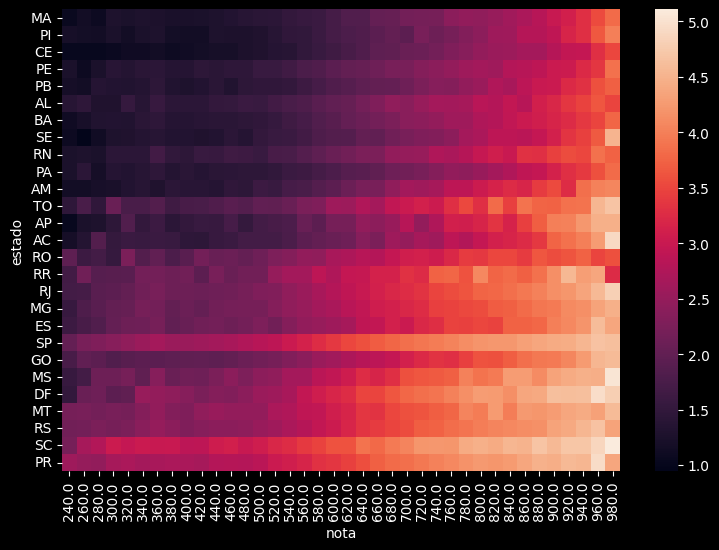

In [152]:
data = renda_redacao.reset_index()
mask1 = data['nota'] > 220
mask2 = data['nota'] < 1000
data_filtered = data[mask1 & mask2].pivot_table(
    values='renda', index='estado', columns='nota', aggfunc='mean'
)
# ordenando as colounas dos estados de acordo com a região.
data_filtered.index = pd.CategoricalIndex(
    data_filtered.index, categories = [
        "MA", "PI", "CE", "PE", "PB", "AL", "BA", "SE", "RN",
        "PA", "AM", "TO", "AP", "AC", "RO", "RR",
        "RJ", "MG", "ES","SP",
        "GO", "MS", "DF", "MT",
        "RS", "SC", "PR"
    ], ordered = True
)
data_filtered.sort_index(level=0, inplace=True)

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_filtered, fmt="d", ax=ax)

<AxesSubplot: xlabel='renda', ylabel='nota'>

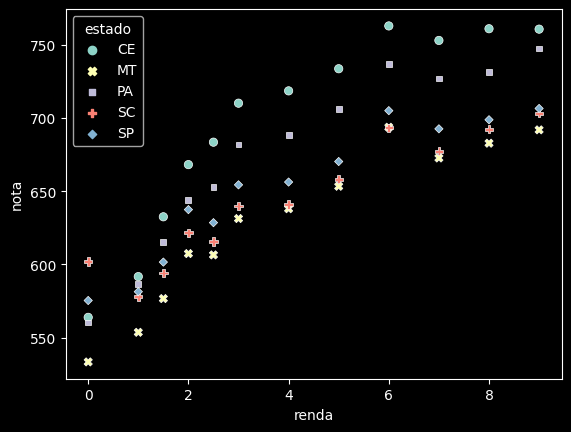

In [164]:
data = renda_redacao.reset_index()
data = renda_redacao[
    renda_redacao["estado"].isin((
        "CE", "PA", "MT", "SC", "SP"
    ))
].reset_index()

mask1 = data['nota'] > 220
mask2 = data['nota'] < 1000
# agrupamos por estado e renda, calculando a média das notas
data_filtered = data[mask1 & mask2].groupby(
    ['estado', 'renda']
).mean(numeric_only=False).round(1)
data_filtered.drop(columns=('index'), inplace=True)

sns.scatterplot(
    data=data_filtered, x="renda", y="nota", hue="estado", style="estado"
)